***
# Modele de prédiction
***

In [96]:
# ====== Importer les library ====== #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report,  confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer


pd.set_option('display.max_columns', None)

In [2]:
# ====== Déterminer les path ====== #
import os
cwd = os.getcwd()

df_path = cwd + '\\dataframe\\'

In [3]:
# ====== Importer les df ====== #
df = pd.read_hdf(df_path + 'df_merge.h5')

df.head(2)

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,comment_count,like_count,message_comments,mainTopic,message_posts,secondTopic,shares,title,time_difference,year,month,weekday,IDENTITY_ATTACK_cube,INSULT_cube,PROFANITY_cube,SEVERE_TOXICITY_cube,THREAT_cube,TOXICITY_cube,comment_count_cube,like_count_cube,shares_cube,messages_clean,emojis,emojis_text,positive,neutral,negative,emoji_count,title_classify,comment_lenght,label,score,AT,question_label,question_score,question_bool
0,0.102216,0.651296,0.664565,0.350583,0.029933,0.588517,0,0,"Faux, ce ne sera jamais le temps pour lui car ...",composer-preview,HÉLÈNE BUZZETTI / Jagmeet Singh a soutenu que ...,7FJ4TUHKEFEXFIZI6DY2WAQE4E,0,Les incohérences de l’ingérence,3.0,2023,6,4,0.467562,0.866814,0.872661,0.705121,0.310492,0.838017,0.0,0.0,0.0,Faux jamais temps réélu parti crève faim Jamai...,[],[],0.077610,0.130838,0.791552,0,Environnement,52,LABEL_0,0.988207,0,LABEL_0,0.988207,0
1,0.005476,0.167515,0.255499,0.006981,0.005647,0.176317,1,1,Mon dieu!! On nous prend sérieusement pour des...,composer-preview,HÉLÈNE BUZZETTI / Jagmeet Singh a soutenu que ...,7FJ4TUHKEFEXFIZI6DY2WAQE4E,0,Les incohérences de l’ingérence,18.0,2023,6,4,0.176257,0.551253,0.634546,0.191119,0.178081,0.560745,1.0,1.0,0.0,dieu prend sérieusement idiots,[😅],[grinning_face_with_sweat],0.697028,0.047872,0.255100,1,Environnement,10,LABEL_0,0.987274,0,LABEL_0,0.987274,0


In [12]:
def normalizeCols(df, cols):
    for col in cols:
        df[col]=(df[col]-df[col].min())/(df[col].max()-df[col].min())
    return df

In [120]:
# ====== Baseline ====== #
df_model = df.copy()
df_model['comments_binary'] = np.where(df_model['comment_count']==0, 0, 1)

col_to_keep = ['IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'SEVERE_TOXICITY', 'THREAT', 'TOXICITY', 'like_count', 'shares', 'comments_binary']

df_model = df_model[col_to_keep]

# independent values 
col_independent = []
for col in df_model.columns.tolist():
    if (col != 'comments_binary') & (col != 'comment_count'):
        col_independent.append(col)

if 'comments_binary' in df_model.columns.tolist():
    col_dependent = 'comments_binary'
else :
    col_dependent = 'comment_count'


# normalizeCols(df_model, ['like_count', 'shares'])

# undersampling = False
undersampling = True

df_model.head(2)

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,like_count,shares,comments_binary
0,0.102216,0.651296,0.664565,0.350583,0.029933,0.588517,0,0,0
1,0.005476,0.167515,0.255499,0.006981,0.005647,0.176317,1,0,1


In [125]:
# ======= Tout les attributs ======= #
df_model = df.copy()
df_model['comments_binary'] = np.where(df_model['comment_count']==0, 0, 1)


df_model = pd.get_dummies(df_model, columns = ['year', 'weekday', 'title_classify'])

col_to_keep = ['IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'SEVERE_TOXICITY', 'THREAT', 'TOXICITY', 'like_count', 'shares', 'time_difference', 'positive', 'negative', 'comment_lenght', 'AT', 'question_bool', 'comments_binary']
columns = ['year', 'weekday', 'title_classify']

# Include hotencoded attributs
for col in df_model.columns.to_list():
    for column in columns:
        if column in col:
            col_to_keep.append(col)


df_model = df_model[col_to_keep]

if  'time_difference' in col_to_keep :
    df_model['time_difference'] = np.where(df_model['time_difference']<0, 0, df_model['time_difference'])

# independent values 
col_independent = []
for col in df_model.columns.tolist():
    if (col != 'comments_binary') & (col != 'comment_count'):
        col_independent.append(col)

if 'comments_binary' in df_model.columns.tolist():
    col_dependent = 'comments_binary'
else :
    col_dependent = 'comment_count'

# Drop negatif time_difference
df_model = df_model.loc[df_model['time_difference']>0].copy()


# Normalize columns
cols = ['like_count', 'shares', 'time_difference', 'comment_lenght']
df_model = normalizeCols(df_model, cols)
df_model.head()

undersampling = True
df_model.head()

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,like_count,shares,time_difference,positive,negative,comment_lenght,AT,question_bool,comments_binary,year_2020,year_2021,year_2022,year_2023,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,title_classify_COVID,title_classify_Environnement,title_classify_Justice,title_classify_Politique,title_classify_Santé,title_classify_Sport,title_classify_Technologie,title_classify_Économie,title_classify_Éducation
0,0.102216,0.651296,0.664565,0.350583,0.029933,0.588517,0.000000,0.0,0.000001,0.077610,0.791552,0.039658,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,0.005476,0.167515,0.255499,0.006981,0.005647,0.176317,0.001196,0.0,0.000012,0.697028,0.255100,0.006998,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,0.029144,0.269578,0.016753,0.006104,0.005864,0.246033,0.000000,0.0,0.000060,0.243069,0.667599,0.046656,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
3,0.036105,0.402434,0.479813,0.023411,0.008220,0.372227,0.000000,0.0,0.000066,0.685404,0.189553,0.008554,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,0.280349,0.520819,0.163573,0.169603,0.008790,0.439655,0.000000,0.0,0.000066,0.158446,0.599248,0.012442,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [10]:
df_model.describe()

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,like_count,shares,time_difference,positive,negative,comment_lenght,AT,question_bool,comments_binary,year_2020,year_2021,year_2022,year_2023,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,title_classify_COVID,title_classify_Environnement,title_classify_Justice,title_classify_Politique,title_classify_Santé,title_classify_Sport,title_classify_Technologie,title_classify_Économie,title_classify_Éducation
count,9.268930e+05,926893.000000,926893.000000,9.268930e+05,926893.000000,926893.000000,926893.00000,926893.000000,9.268930e+05,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000
mean,1.145923e-02,0.109345,0.052690,1.366041e-02,0.010193,0.102814,1.32718,287.378196,1.835806e+03,0.370189,0.442540,22.257521,0.000900,0.109358,0.123938,0.375859,0.341798,0.166345,0.115998,0.136060,0.154557,0.155660,0.150881,0.150744,0.129400,0.122697,0.176571,0.106229,0.054465,0.142701,0.072169,0.066346,0.072634,0.065682,0.243203
std,4.016004e-02,0.163214,0.120186,5.624640e-02,0.035218,0.140308,5.99592,1862.016274,2.075732e+04,0.247017,0.237336,35.486301,0.029983,0.312088,0.329511,0.484344,0.474312,0.372390,0.320223,0.342852,0.361482,0.362533,0.357934,0.357800,0.335642,0.328089,0.381305,0.308131,0.226933,0.349768,0.258768,0.248887,0.259535,0.247725,0.429017
min,3.613072e-08,0.002280,0.000000,3.725290e-08,0.000000,0.000005,0.00000,0.000000,1.000000e+00,0.003074,0.000853,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.249071e-04,0.009546,0.008888,4.243851e-04,0.005321,0.008419,0.00000,7.000000,1.300000e+02,0.163339,0.260180,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.590908e-03,0.027731,0.011287,1.220703e-03,0.005497,0.034513,0.00000,27.000000,4.920000e+02,0.322117,0.419297,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.512681e-03,0.137888,0.022218,4.711151e-03,0.006233,0.151587,1.00000,109.000000,1.515000e+03,0.534297,0.624711,26.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.491525e-01,0.973575,0.991138,9.502075e-01,0.968038,0.981763,836.00000,25872.000000,1.418885e+06,0.996014,0.988329,1287.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [132]:
df_model.to_hdf(cwd + '\\dataframe\\' + 'df_model.h5', key='s')

***
### Fonction
***

In [53]:
def modelScore(y_test, y_prediction):
    tn, fp, fn, tp = confusion_matrix(y_test, y_prediction).ravel()
    
    evaluation = round(tp / (tp+fp+fn), 2)
    print(f"Évaluation : {evaluation}")

    accuracy = accuracy_score(y_test, y_prediction)
    print(f"Accuracy: {accuracy:.2f}")

    precision = precision_score(y_test, y_prediction)
    print(f"Precision: {precision:.2f}")

    recall = recall_score(y_test, y_prediction)
    print(f"Recall: {recall:.2f}")

    f1 = f1_score(y_test, y_prediction)
    print(f"f1_score: {f1:.2f}")

def costumMetric(y_test, y_prediction):
    fp, fn, tp = confusion_matrix(y_test, y_prediction).ravel()
    evaluation = round(tp / (tp+fp+fn), 2)
    return evaluation


def custom_evaluation_score(y_true, y_pred):
    TP = ((y_true == 1) & (y_pred == 1)).sum()
    FP = ((y_true == 0) & (y_pred == 1)).sum()
    FN = ((y_true == 1) & (y_pred == 0)).sum()
    precision = TP / (TP + FP + FN)
    return precision


def featureImportance(classifier, X_test, y_test):
    feature_names = X_test.columns
    imps = permutation_importance(classifier, X_test, y_test)
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': imps.importances_mean})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    print("\nFeature Importance:\n", feature_importance_df)
    # https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance


def confusionMatricePlot(y_test, y_prediction, save_Name=None):
    cm = confusion_matrix(y_test, y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    if save_Name != None:
        plt.savefig(f'{save_Name}.png')
    plt.show()


def durationTime(start_time, end_time):
    duration = (end_time - start_time)
    minutes = duration // 60
    seconds = duration % 60
    print(f'Running time (min): {int(minutes)}.{int(seconds)}')


def randomUnderSampling(X, y):
    X = df_model[col_independent]
    y = df_model[col_dependent]
    print('Original dataset shape %s' % Counter(y))

    rus = RandomUnderSampler(random_state=42)
    X_res, y_res = rus.fit_resample(X, y)

    print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

***
### Logit
***

In [126]:
# https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Probit.html#statsmodels.discrete.discrete_model.Probit
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

start_time = time.time()

X = df_model[col_independent]
y = df_model[col_dependent]
if undersampling == True: 
    X, y = randomUnderSampling(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True) 
classifier = LogisticRegression(random_state=0, class_weight='balanced', max_iter=500).fit(X_train, y_train)

custom_scorer = make_scorer(custom_evaluation_score)
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring=custom_scorer)

classifier.fit(X_train, y_train)
y_prediction = classifier.predict(X_test)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

end_time = time.time()


Original dataset shape Counter({0: 812016, 1: 114877})
Resampled dataset shape Counter({0: 114877, 1: 114877})
Cross-validation scores: [0.40939537 0.40580499 0.41205894 0.40571765 0.41342276]
Mean CV score: 0.4092799412882312


In [112]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.60      0.87      0.71     28789
           1       0.76      0.42      0.54     28701

    accuracy                           0.65     57490
   macro avg       0.68      0.64      0.63     57490
weighted avg       0.68      0.65      0.63     57490



In [127]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.41
Accuracy: 0.63
Precision: 0.66
Recall: 0.52
f1_score: 0.58
Running time (min): 0.12


***
### Random forest
***

In [20]:
# df_model = df_model.head(100)

In [134]:
# Code pour optimiser les hyperparamètres
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import numpy as np

def costumMetric(y_test, y_prediction):
    fp, fn, tp = confusion_matrix(y_test, y_prediction).ravel()
    denominator = (tp+fp+fn)
    if denominator == 0:
        return 0
    evaluation = round(tp / (tp+fp+fn), 2)
    return evaluation

custom_scorer = make_scorer(costumMetric, greater_is_better=True)

X = df_model[col_independent]
y = df_model[col_dependent]
if undersampling == True: 
    X, y = randomUnderSampling(X, y)

param_dist = {
    'n_estimators': np.random.randint(100, 500, 10),
    'max_depth': [None] + list(np.linspace(3, 20, 5).astype(int)),
    'min_samples_split': list(range(2, 21, 2)),
    'min_samples_leaf': list(range(1, 21, 2)),
    'max_features': ['sqrt', 'log2', None]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True) 

random_search = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
print("Best hyperparameters:", random_search.best_params_)

# y_pred = random_search.predict(X_test)
# print(f"Test set evaluation: {costumMetric(y_test, y_pred)}")

Original dataset shape Counter({0: 812016, 1: 114877})
Resampled dataset shape Counter({0: 114877, 1: 114877})


C:\Users\Charles_tour\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


Best hyperparameters: {'n_estimators': 390, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 'sqrt', 'max_depth': 20}


In [19]:
# df_model = df_model.head(10000).copy()

In [135]:
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()

X = df_model[col_independent]
y = df_model[col_dependent]

if undersampling == True: 
    X, y = randomUnderSampling(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True) 
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]

classifier = RandomForestClassifier(n_estimators=390, min_samples_split=20, min_samples_leaf=15, max_features='sqrt', max_depth=20)
# classifier = RandomForestClassifier()

custom_scorer = make_scorer(custom_evaluation_score)
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring=custom_scorer)

classifier.fit(X_train, y_train)
y_prediction = classifier.predict(X_test)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

end_time = time.time()
# 34

Original dataset shape Counter({0: 812016, 1: 114877})
Resampled dataset shape Counter({0: 114877, 1: 114877})
Cross-validation scores: [0.53414957 0.53592456 0.53589438 0.53492412 0.53964535]
Mean CV score: 0.5361075968693861


In [137]:
# ====== Save model ====== #
from joblib import dump, load
dump(classifier, 'randomForest.joblib')

['randomForest.joblib']

In [136]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.54
Accuracy: 0.71
Precision: 0.72
Recall: 0.68
f1_score: 0.70
Running time (min): 12.2


In [124]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94    203084
           1       0.61      0.14      0.23     28727

    accuracy                           0.88    231811
   macro avg       0.75      0.56      0.58    231811
weighted avg       0.86      0.88      0.85    231811



In [15]:
from sklearn.metrics import classification_report

target_names = ['0', '1']
print(classification_report(y_test, y_prediction, target_names=target_names))

              precision    recall  f1-score   support

           0       0.70      0.73      0.72     28846
           1       0.72      0.68      0.70     28593

    accuracy                           0.71     57439
   macro avg       0.71      0.71      0.71     57439
weighted avg       0.71      0.71      0.71     57439



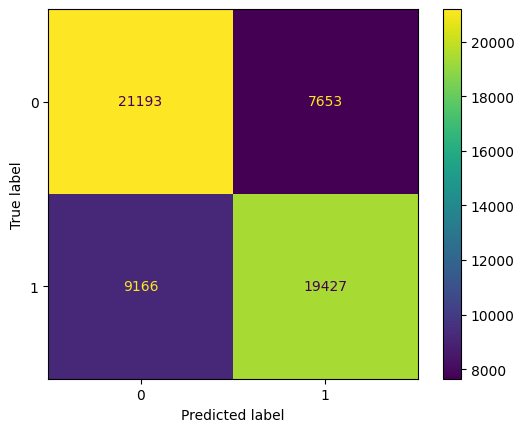

In [14]:
confusionMatricePlot(y_test, y_prediction, 'DecisionTreeFinal')

In [22]:
# Feature importance based on mean decrease in impurity

start_time = time.time()
feature_names = X.columns.to_list()
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.036 seconds


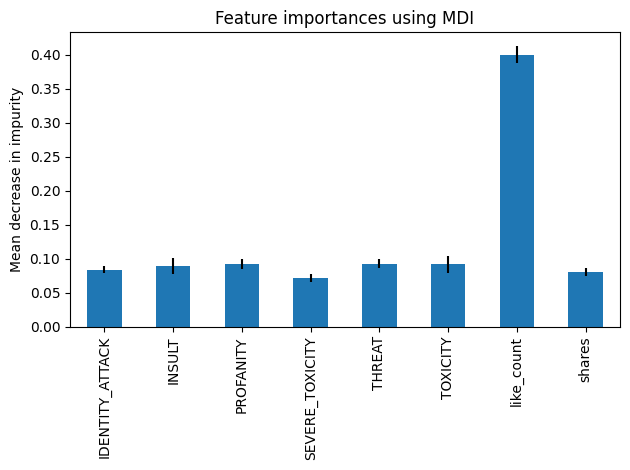

In [23]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.savefig('FeatureImportance.png', dpi=300, bbox_inches='tight')
fig.tight_layout()

***
### Naive Bayes
***

In [78]:
from sklearn.naive_bayes import GaussianNB

start_time = time.time()

X = df_model[col_independent]
y = df_model[col_dependent]
if undersampling == True: 
    X, y = randomUnderSampling(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=142, test_size=0.25, shuffle=True, )
classifier = GaussianNB()

custom_scorer = make_scorer(custom_evaluation_score)
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring=custom_scorer)

classifier.fit(X, y)
y_prediction = classifier.predict(X_test)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

end_time = time.time()

Original dataset shape Counter({0: 812261, 1: 114980})
Resampled dataset shape Counter({0: 114980, 1: 114980})
Cross-validation scores: [0.22389811 0.24841543 0.22465999 0.24311876 0.22594048]
Mean CV score: 0.2332065535951983


In [79]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.24
Accuracy: 0.60
Precision: 0.85
Recall: 0.25
f1_score: 0.38
Running time (min): 0.0


In [113]:
from sklearn.naive_bayes import MultinomialNB

start_time = time.time()

X = df_model[col_independent]
y = df_model[col_dependent]
if undersampling == True: 
    X, y = randomUnderSampling(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=142, test_size=0.25, shuffle=True, )
classifier = MultinomialNB(alpha=1)

custom_scorer = make_scorer(custom_evaluation_score)
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring=custom_scorer)

classifier.fit(X, y)
y_prediction = classifier.predict(X_test)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

end_time = time.time()

Original dataset shape Counter({0: 812261, 1: 114980})
Resampled dataset shape Counter({0: 114980, 1: 114980})
Cross-validation scores: [0.43255079 0.43566735 0.43211494 0.4404816  0.43368392]
Mean CV score: 0.4348997200537049


In [88]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.39
Accuracy: 0.54
Precision: 0.54
Recall: 0.58
f1_score: 0.56
Running time (min): 0.0


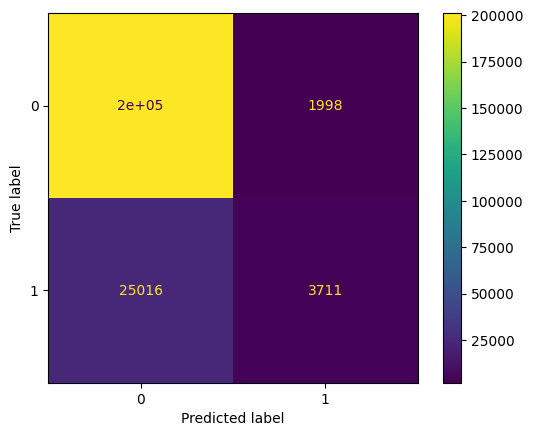

In [73]:
confusionMatricePlot(y_test, y_prediction)

In [114]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.62      0.72      0.66     28739
           1       0.66      0.56      0.61     28751

    accuracy                           0.64     57490
   macro avg       0.64      0.64      0.64     57490
weighted avg       0.64      0.64      0.64     57490



***
### Gradient-Boosting
***

In [93]:
# Code pour optimiser les hyperparamètres
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import numpy as np

def costumMetric(y_test, y_prediction):
    fp, fn, tp = confusion_matrix(y_test, y_prediction).ravel()
    denominator = (tp+fp+fn)
    if denominator == 0:
        return 0
    evaluation = round(tp / (tp+fp+fn), 2)
    return evaluation

custom_scorer = make_scorer(costumMetric, greater_is_better=True)

X = df_model[col_independent]
y = df_model[col_dependent]
if undersampling == True: 
    X, y = randomUnderSampling(X, y)

param_dist = {
    'n_estimators': np.random.randint(100, 500, 10),
    'max_depth': [None] + list(np.linspace(3, 20, 5).astype(int)),
    'min_samples_split': list(range(2, 21, 2)),
    'learning_rate': np.linspace(0.5, 1.0, 20).tolist()
}

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True) 

random_search = RandomizedSearchCV(
    GradientBoostingClassifier(),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
print("Best hyperparameters:", random_search.best_params_)

# y_pred = random_search.predict(X_test)
# print(f"Test set evaluation: {costumMetric(y_test, y_pred)}")

Original dataset shape Counter({0: 812016, 1: 114877})
Resampled dataset shape Counter({0: 114877, 1: 114877})


C:\Users\Charles_tour\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


Best hyperparameters: {'n_estimators': 272, 'min_samples_split': 16, 'max_depth': None, 'learning_rate': 0.8157894736842105}


In [115]:
from sklearn.ensemble import GradientBoostingClassifier

start_time = time.time()

X = df_model[col_independent]
y = df_model[col_dependent]

if undersampling == True: 
    X, y = randomUnderSampling(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, shuffle=True)

classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0, min_samples_split=2).fit(X_train, y_train)
# classifier = GradientBoostingClassifier(n_estimators=272, learning_rate=0.8157894736842105, random_state=0, min_samples_split=16).fit(X_train, y_train)

classifier.score(X_train, y_train)

custom_scorer = make_scorer(custom_evaluation_score)
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring=custom_scorer)

y_prediction = classifier.predict(X_test)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
end_time = time.time()

Original dataset shape Counter({0: 812261, 1: 114980})
Resampled dataset shape Counter({0: 114980, 1: 114980})
Cross-validation scores: [0.46642781 0.46606481 0.47806997 0.4713509  0.47570934]
Mean CV score: 0.4715245672603177


In [107]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.11
Accuracy: 0.88
Precision: 0.65
Recall: 0.11
f1_score: 0.19
Running time (min): 2.21


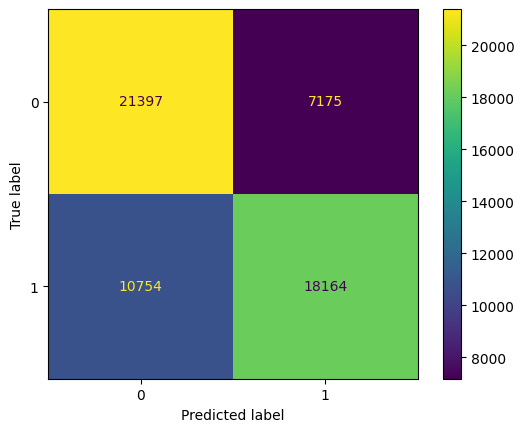

In [63]:
confusionMatricePlot(y_test, y_prediction)

In [116]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.65      0.75      0.70     28572
           1       0.71      0.59      0.65     28918

    accuracy                           0.67     57490
   macro avg       0.68      0.67      0.67     57490
weighted avg       0.68      0.67      0.67     57490

